In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.integrate as integrate
%matplotlib inline

In [605]:
!pwd

/Users/zeus/eigentest


In [2]:

def thomas_alg(a,b,c,d):
    """Thomas algorithm to solve the tridiagonal system"""
    n = len(d)
    
    cp = np.zeros(c.shape)
    dp = np.zeros(d.shape)
    sol = np.zeros(d.shape)
    cp[0] = c[0]/b[0]
    dp[0] = d[0]/b[0]
    
    for i in range(1,n-1):
        cp[i] = c[i]/(b[i] - a[i-1]*cp[i-1])

    for i in range(1,n):
        dp[i] = (d[i] - a[i-1]*dp[i-1])/(b[i] - a[i-1]*cp[i-1])
    
    sol[-1] = dp[-1]
    for i in range(n-1)[::-1]:
        sol[i] = dp[i] - cp[i]*sol[i+1]
        
    return sol
def thomas_alg_block(a,b,c,d):
    """Thomas algorithm to solve the block tridiagonal system"""
    n = len(d)
    m = d[0].shape[0]
    
    cp = [None]*len(c)
    dp = [None]*len(d)
    sol =[None]*len(d)
    cp[0] = np.linalg.solve(b[0],c[0])
    dp[0] = np.linalg.solve(b[0],d[0])
    
    for i in range(1,n-1):
        cp[i] = np.linalg.solve(b[i] - np.dot(a[i-1],cp[i-1]),c[i])

    for i in range(1,n):
        dp[i] = np.linalg.solve(b[i] - np.dot(a[i-1],cp[i-1]),d[i] - np.dot(a[i-1],dp[i-1]))
    
    sol[-1] = dp[-1]
    for i in range(n-1)[::-1]:
        sol[i] = dp[i] - np.dot(cp[i],sol[i+1])
    return np.array(sol)

class Planet():
    def __init__(self, a=1, mp=1e-3,eps=.6, hp = .05):
        self.a = a
        self.mp = mp
        self.eps = eps
        self.hp = hp
        self.soft = eps*hp
        self.soft2 = self.soft*self.soft
        self.omp = a**(-1.5)
    def potential(self,u,x):
        return (-self.mp/np.sqrt(x**2 + self.soft2 + self.a**2 - 2*x*self.a*np.cos(u)) 
                + self.mp*x**(-2) * planet.a * np.cos(u) )
    
    def dr_potential(self,u,x): 
        return ( self.mp*(x - planet.a*np.cos(u))/np.sqrt(x**2 + planet.a**2 + planet.soft2 - 2*planet.a*x*np.cos(u))  
                - self.mp*2 * planet.a * np.cos(u) * x**(-3) )
    def dp_potential(self,u,x):
        return (self.mp*self.a*x*np.sin(u) (x**2 + self.soft2 + self.a**2 - 2*x*self.a*np.cos(u))**(-1.5)
                - self.mp*x**(-2) * planet.a * np.sin(u) )
                               
class Matrix():
    def __init__(self, ld,md,ud,fd):
        self.ld = ld
        self.md = md
        self.ud = ud
        self.fd = fd
class Disk():
    def __init__(self,mu=-.5,delta=-.5,sig0=1,h=.1,f=0,alpha=0,eta=0,omf=0,planets=None,iso=False,max_m=100):
        self.mu = mu
        self.delta = delta
        self.sig0 = sig0
        self.omf = omf
        self.h = h
        self.h2 = h*h
        self.f = f
        self.alpha = alpha
        self.iso = iso
        self.eta = eta
        self.gamma = self.mu + 2*self.f+.5
        self.planets = planets
    
    def omega2(self,r):
        if self.iso:
            return r**(-3) + self.c2(r)/(r*r) *(self.delta+self.mu)
        else:
            return r**(-3) + self.c2(r)/(r*r) *self.mu
    def kappa2(self,r):
        if self.iso:
            return r**(-3) + self.c2(r)/(r*r) *( (2+self.delta)*(self.delta+self.mu))
        else:
            return r**(-3) + self.c2(r)/(r*r) *(self.mu*(2 + self.delta))
    def k2om(self,r):
        k2 = self.kappa2(r)
        om = np.sqrt(self.omega2(r))
        return k2/(2*om)
    def sigma(self,r):
        return self.sig0 * r**self.mu
    def c2(self,r):
        return self.h2 * r**self.delta
    def pres(self,r):
        return self.sigma(r)*self.c2(r)
    def dsdr(self,r):
        return self.sigma(r)*self.mu/r
    def dpdr(self,r):
        if self.iso:
            return self.pres(r)*(self.mu+self.delta)/r
        else:
            return self.c2(r) * self.dsdr(r)
    def dc2dr(self,r):
        return self.c2(r)*self.delta/r
    def omega(self,r):
        return np.sqrt(self.omega2(r))
    def H(self,r):
        return self.h * r * r**(self.f)
    def Nu(self,r):
        return self.alpha * self.H(r)**2 * self.omega(r)
    def kappa(self,r):
        return np.sqrt(self.kappa2(r))
def construct_matrix(ld,md,ud):
    n = len(md)
    m = ld[0].shape[0]
    mat = np.zeros((m*n,m*n),dtype='complex')
    mat[:m,:m] = md[0]
    mat[:m,m:2*m] = ud[0]
    mat[-m:,-m:] = md[-1]
    mat[-m:,-2*m:-m] = ld[-1]
    for i in range(1,n-1):
        mat[i*m:(i+1)*m, i*m:(i+1)*m] = md[i]
        mat[i*m:(i+1)*m, (i+1)*m:(i+2)*m] = ud[i]
        mat[i*m:(i+1)*m, (i-1)*m:i*m] = ld[i-1]
    return mat

def main_diag(r,m,disk,dlr,onesided=False):
    om = disk.omega(r)
    c2 = disk.c2(r)
    k2om = disk.k2om(r)
    invdlr2 = -2./(dlr*dlr)
    res = np.zeros((3,3),dtype='complex')
    res[0,0] = 1j*m*(om - disk.omf)
    res[1,1] = 1j*m*(om - disk.omf)
    res[2,2] = 1j*m*(om - disk.omf)
    res[0,1] = -2*om
    res[1,0] = k2om
    if disk.iso:
        res[1,2] = 1j*m*c2/r
        res[2,0] = (disk.mu + 1)/r
        res[2,1] = 1j*m/r
    else:
        res[1,2] = 1j*m/r
        res[2,0] = (disk.mu + 1)*c2/r
        res[2,1] = 1j*m*c2/r
#     nu = -disk.Nu(r)
#     ir2 = 1./(r*r)
#     res[0,0] -= nu*(2 + m*m + (1- disk.eta)*disk.gamma)*ir2
#     res[0,1] -= nu*1j*m*(3 + (1+disk.gamma)*disk.eta)*ir2
#     res[1,0] += nu*1j*m*(3 - disk.eta+disk.gamma)*ir2
    
#     res[1,1] -= nu*(1 + disk.gamma + m*m*(2-disk.eta)) *ir2
#     res[0,0] += nu*(2+disk.eta)*ir2*invdlr2
#     res[1,1] += nu*ir2*invdlr2
#     if disk.iso:
#         res[0,2] += nu*1j*m*(k2om - 2*om)/r
#     else:
#         res[0,2] += nu*1j*m*(k2om - 2*om)/(r*c2) 
#         res[1,2] -= nu*1j*m*(k2om - 2*om)/(r*c2) * disk.delta
    
    return res
def upper_diag(r,m,disk,dlr,onesided=False):
    res = np.zeros((3,3),dtype='complex')
    c2 = disk.c2(r)
    k2om = disk.k2om(r)
    om = disk.omega(r)
    invdlr = .5/dlr
    invdlr2 = 1./dlr**2
    if disk.iso:
        res[0,2] = disk.c2(r)/r * invdlr
        res[2,0] = invdlr / r
    else:
        res[0,2] = 1./r * invdlr
        res[2,0] = disk.c2(r)*invdlr / r
    nu = -disk.Nu(r)
    ir2 = 1./(r*r)
    res[0,0] += nu*(2*disk.gamma+1)*ir2*invdlr
    res[0,1] += nu*1j*m*(1+disk.eta)*ir2*invdlr
    res[1,0] += nu*(1-disk.eta)*1j*m*ir2*invdlr
    res[1,1] += nu*disk.gamma*ir2*invdlr
    res[0,0] += nu*(2+disk.eta)*ir2*invdlr2
    res[1,1] += nu*ir2*invdlr2
    if disk.iso:
        res[1,2] += nu*1j*m*(k2om-2*om)/r*invdlr
    else:
         res[1,2] += nu*1j*m*(k2om-2*om)/(r*c2)*invdlr
    
    
    return res
def lower_diag(r,m,disk,dlr,onesided=False):
    res = np.zeros((3,3),dtype='complex')
    k2om = disk.k2om(r)
    om = disk.omega(r)
    c2 = disk.c2(r)
    invdlr = -.5/dlr
    invdlr2 = 1./dlr**2
    if disk.iso:
        res[0,2] = disk.c2(r)/r * invdlr
        res[2,0] = invdlr / r
    else:
        res[0,2] = 1./r * invdlr
        res[2,0] = disk.c2(r)*invdlr / r
    
    nu = -disk.Nu(r)
    ir2 = 1./(r*r)
    res[0,0] += nu*(2*disk.gamma+1)*ir2*invdlr
    res[0,1] += nu*1j*m*(1+disk.eta)*ir2*invdlr
    res[1,0] += nu*(1-disk.eta)*1j*m*ir2*invdlr
    res[1,1] += nu*disk.gamma*ir2*invdlr
    res[0,0] += nu*(2+disk.eta)*ir2*invdlr2
    res[1,1] += nu*ir2*invdlr2
    if disk.iso:
        res[1,2] += nu*1j*m*(k2om-2*om)/r *invdlr
    else:
         res[1,2] += nu*1j*m*(k2om-2*om)/(r*c2) *invdlr
    return res

def force(x,m,disk,planet,dlr):
    """Potential due to planet
    Phi(r,phi) = -G q /Sqrt( eps^2 + r^2 + a^2 - 2 r a Cos(phi))  + q om^2 a r cos(phi)
    dr_Phi(r,phi) = G q (r - a Cos(phi)) ( eps^2 + r^2 + a^2 - 2 r a Cos(phi))^(-3/2)  + q (kappa^2 - 3 om^2) a cos(phi)
    """
    integrand = lambda u: (-1./np.sqrt(x**2 + planet.a**2 + planet.soft2 - 2*planet.a*x*np.cos(u)) 
                           + np.cos(u)*planet.a/(x*x))
    dr_integrand = lambda u: ( (x - planet.a*np.cos(u)) * (x**2 + planet.a**2 + planet.soft2 - 2*planet.a*x*np.cos(u))**(-1.5)
                               - 2*np.cos(u)*planet.a/(x*x*x))
                               
    
    dp_pot = integrate.quad(lambda u: np.cos(m*u)*integrand(u),-np.pi,np.pi)[0]/(2*np.pi)
    dr_pot = integrate.quad(lambda u: np.cos(m*u)*dr_integrand(u),-np.pi,np.pi)[0]/(2*np.pi)
#     if m == 1:
#         dp_pot += disk.omega2(x) * planet.a * x * .5
#         dr_pot += (disk.kappa2(x) - 3*disk.omega2(x)) * planet.a*x*.5
    res = np.zeros((3,1),dtype='complex')
    res[0] = -planet.mp*dr_pot
    res[1] = -1j*m*planet.mp*dp_pot/x
    return res
    
def inner_bc(r0,m,disk,dlr):
    md0 = main_diag(r0,m,disk,dlr)
    if disk.iso:
        md0[2,0] = (disk.mu+disk.delta)/r0
    else:
        md0[2,0] = (disk.mu)*disk.c2(r0)/r0
    md0[2,1] = 0
    #ud0 = upper_diag(r0,m,disk,dlr)
    ud0 = np.zeros((3,3),dtype='complex')
    invdlr = 1./dlr
    if disk.iso:
        ud0[0,2] = disk.c2(r0)/r0 * invdlr
        ud0[2,0] = invdlr / r0
    else:
        ud0[0,2] = 1./r0 * invdlr
        ud0[2,0] = disk.c2(r0)*invdlr / r0
    md0[0,2] -= ud0[0,2]
    md0[2,0] -= ud0[2,0]
#     ud0[2,0] = 0
#     md0[0,2] = -ud0[0,2]
    return md0,ud0
def outer_bc(rn,m,disk,dlr):
    mdn = main_diag(rn,m,disk,dlr)
    if disk.iso:
        mdn[2,0] = (disk.mu+disk.delta)/rn
    else:
        mdn[2,0] = (disk.mu)*disk.c2(rn)/rn
    mdn[2,1] = 0
    #ldn = lower_diag(rn,m,disk,dlr)
    ldn = np.zeros((3,3),dtype='complex')
    invdlr = -1./dlr
    if disk.iso:
        ldn[0,2] = disk.c2(rn)/rn * invdlr
        ldn[2,0] = invdlr / rn
    else:
        ldn[0,2] = 1./rn * invdlr
        ldn[2,0] = disk.c2(rn)*invdlr / rn
    mdn[0,2] -= ldn[0,2]
    mdn[2,0] -= ldn[2,0]

#     ldn[2,0] = 0
#     mdn[0,2] = -ldn[0,2]
    return mdn,ldn
def lw_inner_bc(r0,m,disk,dlr,eps=1):
    md0 = main_diag(r0,m,disk,dlr)
    ud0 = upper_diag(r0,m,disk,dlr)
    ld0 = lower_diag(r0,m,disk,dlr)
    
    rb = r0 * np.exp(-.5*dlr)
    kr = np.sqrt( np.abs(Dfunc(rb,disk.omf,m,disk)/disk.c2(rb)) ) * rb
    
    fac = (1 - .5*eps*1j*kr*dlr)/(1 + .5*eps*1j*kr*dlr)
    
    print(rb,kr,fac)
    
    md0 += fac * ld0
        
    return md0,ud0
def lw_outer_bc(rn,m,disk,dlr,eps=1):
    
    mdn = main_diag(rn,m,disk,dlr)
    udn = upper_diag(rn,m,disk,dlr)
    ldn = lower_diag(rn,m,disk,dlr)
    
    rb = rn * np.exp(+.5*dlr)
    
    
    kr = np.sqrt( np.abs(Dfunc(rb,disk.omf,m,disk)/disk.c2(rb)) ) * rb
    
    fac = (1 + .5*eps*1j*kr*dlr)/(1 - .5*eps*1j*kr*dlr)
    mdn += fac * udn
    
    return mdn,ldn

def Dfunc(r,omp,m,disk):
        return disk.kappa(r)**2 - m*m*(disk.omega(r) - omp)**2
def wkb(kr,r,eps,m,disk):
    return disk.omega(rr) + eps*np.sqrt(disk.kappa(r)**2 + kk**2 * disk.c2(rr)/rr**2)/m

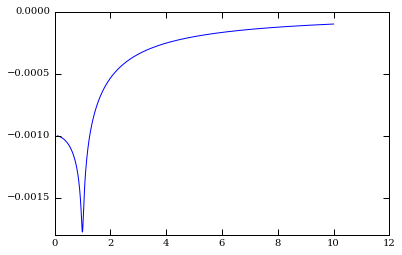

In [655]:
planet = Planet()
r = np.exp( np.linspace( np.log(.1),np.log(10),512))

res = np.array([integrate.quad(planet.potential,-np.pi,np.pi,args=(x,))[0]/(2*np.pi) for x in r])

plt.plot(r,res)

In [652]:
integrate.quad?

In [354]:
r = np.exp( np.linspace( np.log(.1),np.log(10),512))
dlr = np.diff(np.log(r))[0]
disk = Disk(mu=-1,delta=0,omf=1)
planet = Planet(mp=1e-5,a=1,hp=disk.h)

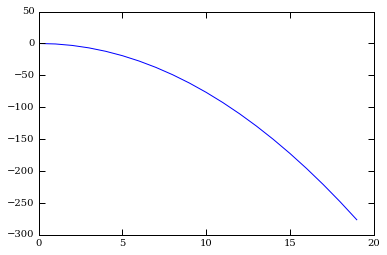

In [406]:
plt.plot(np.arange(20),Dfunc(r[-1],planet.omp,np.arange(20),disk))

In [3]:
def eig(m,ri=.1,ro=10,nr=512,**kargs):
    r = np.exp( np.linspace( np.log(ri),np.log(ro),nr))
    dlr = np.diff(np.log(r))[0]
    disk = Disk(**kargs)
    md = [main_diag(x,m,disk,dlr) for x in r]
    ld = [lower_diag(x,m,disk,dlr) for x in r[1:]]
    ud = [upper_diag(x,m,disk,dlr) for x in r[:-1]]
    md0,ud0 = inner_bc(r[0],m,disk,dlr)
    md[0] = md0
    ud[0] = ud0
    mdn,ldn = outer_bc(r[-1],m,disk,dlr)
    md[-1] = mdn
    ld[-1] = ldn
    mat = construct_matrix(ld,md,ud)
    evals,evec = np.linalg.eig(mat)
    evals *= (-1j)/m
    ind = np.argsort(evals.real)[::-1]
    evals =evals[ind]
    evec = evec[:,ind]
    u = evec[::3,:]
    v = evec[1::3,:]
    s = evec[2::3,:]
    return r,disk, evals,u,v,s

def linear_waves(m, inner_eps = 1, outer_eps = 1, ri=.1, ro=5, nr =512, planet=None,**kargs):
    dlr = np.log(ro/ri)/nr
    r = ri*np.exp(np.arange(nr)*dlr)
    #r = np.exp( np.linspace( np.log(ri),np.log(ro),nr))
    #dlr = np.diff(np.log(r))[0]
    disk = Disk(**kargs)
    md = [main_diag(x,m,disk,dlr) for x in r]
    ld = [lower_diag(x,m,disk,dlr) for x in r[1:]]
    ud = [upper_diag(x,m,disk,dlr) for x in r[:-1]]
    fd = [np.zeros((3,1)) for x in r]
    if planet is not None:
        fd = [force(x,m,disk,planet,dlr) for x in r]
    md0,ud0 = lw_inner_bc(r[0],m,disk,dlr,eps=inner_eps)
    md[0] = md0
    ud[0] = ud0
    mdn,ldn = lw_outer_bc(r[-1],m,disk,dlr,eps=outer_eps)
    md[-1] = mdn
    ld[-1] = ldn
    
    dp_pot = np.array([f[1,0] for f in fd])
    mat = Matrix(ld,md,ud,fd)
    sol = thomas_alg_block(ld,md,ud,fd)
    u = np.array([s[0] for s in sol]).ravel()
    v = np.array([s[1] for s in sol]).ravel()
    sig = np.array([s[2] for s in sol]).ravel()
    if disk.iso:
        sig *= disk.sigma(r)
    else:
        sig *= disk.sigma(r)/disk.c2(r)
    return r,disk,planet,u,v,sig,dp_pot,mat
    

In [106]:
disk.Nu(r)

array([  7.90520003e-07,   7.91678177e-07,   7.92838047e-07, ...,
         3.52081218e-06,   3.52595821e-06,   3.53111172e-06])

In [205]:
m = 1
r,disk,evals,u,v,s = eig(m,nr=512,ri=1.0,ro=10,mu=-1,delta=0,h=.1,alpha=0,iso=True)

In [436]:
m = 3
planet = Planet(mp=.001,hp=.05)
r,disk,planet,u,v,s = linear_waves(m,planet=planet,omf=planet.omp,nr=1024,ri=.1,ro=5,mu=-1,delta=0,h=.1,alpha=1e-2,iso=True)

In [244]:
m = 10
planet = Planet(mp=1,hp=.03,eps=.6)
r,disk,planet,u,v,s,dp_pot,mat = linear_waves(m,planet=planet,inner_eps = 1, outer_eps = 1,
                                   omf=planet.omp,nr=1024,
                                   ri=.5,ro=1.8,mu=0,delta=-1,h=.03,alpha=0,iso=False)

0.499687369789 213.000255055 (0.965122655838002-0.2617981267851267j)


In [245]:
planet.mp

1

In [246]:
phi = np.linspace(-np.pi,np.pi,len(r))
rr,pp = np.meshgrid(r,phi,indexing='ij')
xx = rr*np.cos(pp)
yy = rr*np.sin(pp)
dat = np.zeros(xx.shape,dtype='complex')

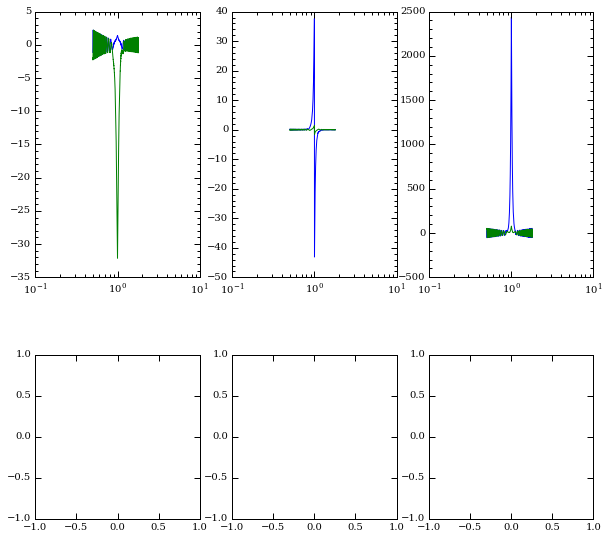

In [247]:
#%matplotlib notebook
plot2d  = False
fig,axes = plt.subplots(2,3,figsize=(10,10))
axes[0,0].plot(r,u.real,r,u.imag)
axes[0,1].plot(r,v.real,r,v.imag)
axes[0,2].plot(r,s.real,r,s.imag)
if plot2d:
    for j,p in enumerate(phi):
        dat[:,j] = u * np.exp(-1j*m*p)
    axes[1,0].pcolormesh(xx,yy,np.real(dat),cmap='viridis')
    for j,p in enumerate(phi):
        dat[:,j] = v * np.exp(-1j*m*p)
    axes[1,1].pcolormesh(xx,yy,np.real(dat),cmap='viridis')
    for j,p in enumerate(phi):
        dat[:,j] = s * np.exp(-1j*m*p)
    axes[1,2].pcolormesh(xx,yy,np.real(dat),cmap='viridis')
plt.subplots_adjust(hspace=.1,wspace=.2)
for ax in axes.flatten()[:3]:
    ax.minorticks_on()
    ax.set_xscale('log')
    #ax.set_xlim(.0003,.2)
for ax in axes.flatten()[-3:]:
    ax.set_aspect('equal')
    ax.plot(np.cos(phi),np.sin(phi),'--w')
    #ax.set_xlim(r[0]-.01,.7)
    #ax.set_xlim(5,r[-1]+.1)

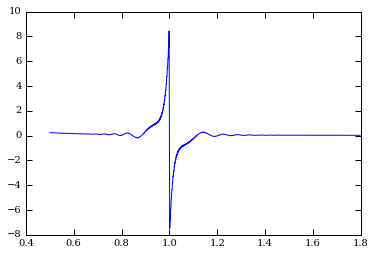

In [250]:
plt.plot(r,(u*np.conj(v)).real)

In [194]:
np.sqrt(10**(-1.5))

0.17782794100389226

In [150]:
n = 1024
dat = np.fromfile('../outputs/matrix.dat',dtype='complex')
print(dat.shape)
ld = dat[:(n-1)*9]
print(ld.shape)
ld = [ld[i*9:(i+1)*9].reshape(3,3) for i in range(n-1)]
dat = dat[(n-1)*9:]
ud = dat[:(n-1)*9]
ud = [ud[i*9:(i+1)*9].reshape(3,3) for i in range(n-1)]
dat = dat[(n-1)*9:]
print(dat.shape)
md = dat[:n*9]
print(md.shape)
md = [md[i*9:(i+1)*9].reshape(3,3) for i in range(n)]
dat = dat[(n)*9:]
fd = dat[:(n)*3]
fd = [fd[i*3:(i+1)*3] for i in range(n)]


(30702,)
(9207,)
(12288,)
(9216,)


In [119]:
np.arange(1024)*np.log()

0.10000000000000002

In [157]:
print(r[-3])
print(mat.md[0])
print(md[0])

1.98252368435
[[    0.00000000 +1.53094118e+02j   -63.23764702 +0.00000000e+00j
     -2.89417417 +3.14326350e+00j]
 [   15.80545841 +0.00000000e+00j     0.00000000 +1.53094118e+02j
      0.00000000 +1.25000000e-01j]
 [-1157.66966690 +1.25730540e+03j     0.00000000 +5.00000000e+01j
      0.00000000 +1.53094118e+02j]]
[[  0.00000000 +1.53094118e+02j -63.23764702 +0.00000000e+00j
   -2.89417417 +0.00000000e+00j]
 [  0.00000000 +0.00000000e+00j   0.00000000 +0.00000000e+00j
   15.80545841 +0.00000000e+00j]
 [  0.00000000 +1.53094118e+02j   0.00000000 +1.25000000e-01j
    0.00000000 +0.00000000e+00j]]


In [188]:
dat = np.fromfile('../outputs/matrix.dat')
dat  = dat[::2] + 1j*dat[1::2]
print(dat[:9].reshape(3,3))
print(mat.md[0])
np.sum(dat - np.hstack(tuple([m.ravel() for m in mat.md])))

[[    0.00000000 +1.53094118e+02j   -63.23764702 +0.00000000e+00j
     -2.89417417 +0.00000000e+00j]
 [   15.80545841 +0.00000000e+00j     0.00000000 +1.53094118e+02j
      0.00000000 +1.25000000e-01j]
 [-1157.66966690 +0.00000000e+00j     0.00000000 +5.00000000e+01j
      0.00000000 +1.53094118e+02j]]
[[    0.00000000 +1.53094118e+02j   -63.23764702 +0.00000000e+00j
     -2.89417417 +3.14326350e+00j]
 [   15.80545841 +0.00000000e+00j     0.00000000 +1.53094118e+02j
      0.00000000 +1.25000000e-01j]
 [-1157.66966690 +1.25730540e+03j     0.00000000 +5.00000000e+01j
      0.00000000 +1.53094118e+02j]]


-1291.6126153149567j

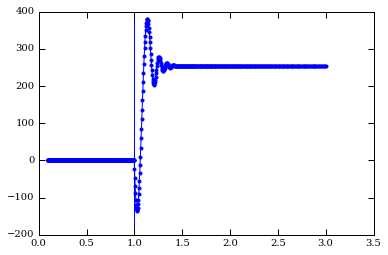

In [804]:
lamex = 2*np.pi*r * 2*np.real(dp_pot * np.conj(s))
ilam = np.zeros(lamex.shape)
ilam[r>=1] = (lamex*r*dlr)[r>=1].cumsum() 
#ilam[r>=1] -= ilam[r>=1][0]
#ilam[r<=1] = -(lamex*r*dlr)[r<=1][::-1].cumsum()[::-1]
plt.plot(r,ilam/planet.mp**2,'.-')

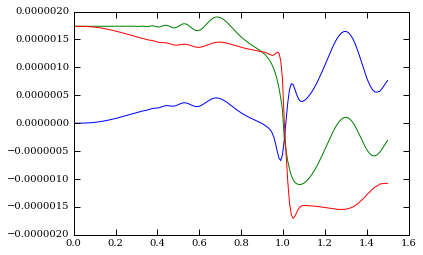

In [826]:
#%matplotlib notebook
fw = 2*np.pi*r**2  * (disk.sigma(r) * 2*np.real(np.conj(u)*v))
lamex = 2*np.pi*r * 2*np.real(dp_pot * np.conj(s))
ilam = np.zeros(lamex.shape)
ilam[r>=1] = (lamex*r*dlr)[r>=1].cumsum()
ilam[r<=1] = -(lamex*r*dlr)[r<=1][::-1].cumsum()[::-1]
plt.plot(r,fw)
plt.plot(r,ilam)
plt.plot(r,ilam-fw)
#plt.xscale('log')

In [772]:
class Args():
    def __init__(self):
        pass
    def add_planet(self,**kargs):
        self.planet = Planet(**kargs)
    def add_disk(self,**kargs):
        self.disk_kargs = kargs
        

In [780]:
arg = Args()
arg.add_planet(mp=.0001,hp=.05,eps=.6)
arg.add_disk(inner_eps = 1, outer_eps = 1,
                                   omf=planet.omp,nr=1024,
                                   ri=.1,ro=3,mu=-.5,delta=-1,h=.05,alpha=1e-2,iso=True)
run_one((10,arg))

2.5411624723778179e-06

In [779]:
def run_one(args):
    m = args[0]
    args = args[1]
    r,disk,planet,u,v,s,dp_pot = linear_waves(m,planet=args.planet,**args.disk_kargs)
    return (2*np.pi*r * 2*np.real(dp_pot * np.conj(s))*r*dlr)[r>=1].cumsum()[-1]

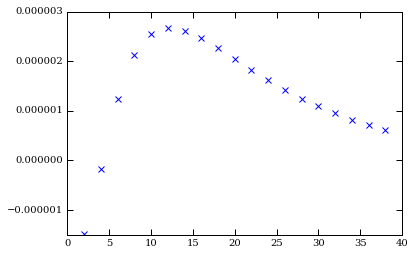

In [782]:
import multiprocessing as mp

arg = Args()
arg.add_planet(mp=.0001,hp=.05,eps=.6)
arg.add_disk(inner_eps = 1, outer_eps = 1,
                                   omf=planet.omp,nr=1024,
                                   ri=.1,ro=3,mu=-.5,delta=-1,h=.05,alpha=1e-2,iso=True)
mvals = np.arange(2,40)[::2]
pool = mp.Pool(4)
TR = pool.map(run_one,[(m,arg) for m in mvals])
plt.figure()
plt.plot(mvals,TR,'x')

In [760]:

mvals = np.arange(2,40)[::2]
TR = np.zeros(mvals.shape)

for i,m in enumerate(mvals):
    planet = Planet(mp=.0001,hp=.05,eps=.6)
    r,disk,planet,u,v,s,dp_pot = linear_waves(m,inner_eps = 1, outer_eps = 1,
                                   planet=planet,omf=planet.omp,nr=1024,
                                   ri=.1,ro=3,mu=-.5,delta=-1,h=.05,alpha=1e-2,iso=True)
    
    TR[i] = (2*np.pi*r * 2*np.real(dp_pot * np.conj(s))*r*dlr)[r>=1].cumsum()[-1]


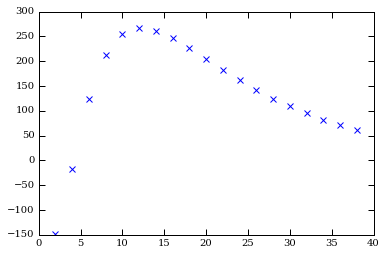

In [786]:
#%matplotlib notebook
plt.figure()
plt.plot(mvals,np.array(TR)/(1e-8),'x')

In [15]:
m = 1
r,disk,evals,u,v,s = eig(m,nr=512,ri=1.0,ro=10,mu=-1,delta=0,h=.05,alpha=0,iso=True)

(-30, 30)

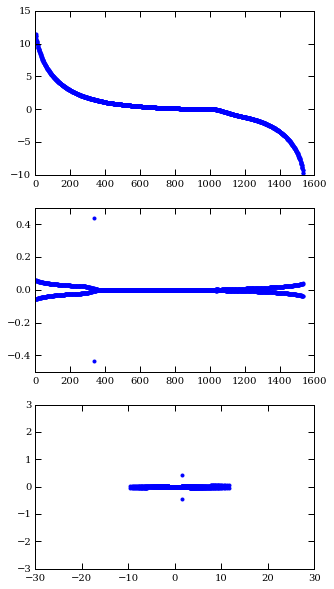

In [16]:
fig,axes = plt.subplots(3,1,figsize=(5,10))
axes[0].plot((evals.real),'.')
axes[1].plot(evals.imag,'.')
axes[2].plot((evals.real/disk.omega(1)),(evals.imag/disk.omega(1)),'.')
axes[2].set_ylim(-3,3)
axes[2].set_xlim(-30,30)

(-0.001, 0.001)

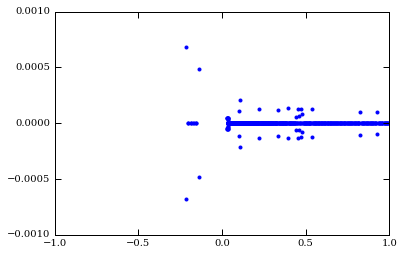

In [17]:
ind = (np.abs(evals.real)>min(disk.omega(r)))&(np.abs(evals.real)<max(disk.omega(r)))
plt.plot(evals.real[ind],evals.imag[ind],'.')
plt.ylim(-1e-3,1e-3)

In [18]:
phi = np.linspace(-np.pi,np.pi,len(r))
rr,pp = np.meshgrid(r,phi,indexing='ij')
xx = rr*np.cos(pp)
yy = rr*np.sin(pp)
dat = np.zeros(xx.shape,dtype='complex')

726


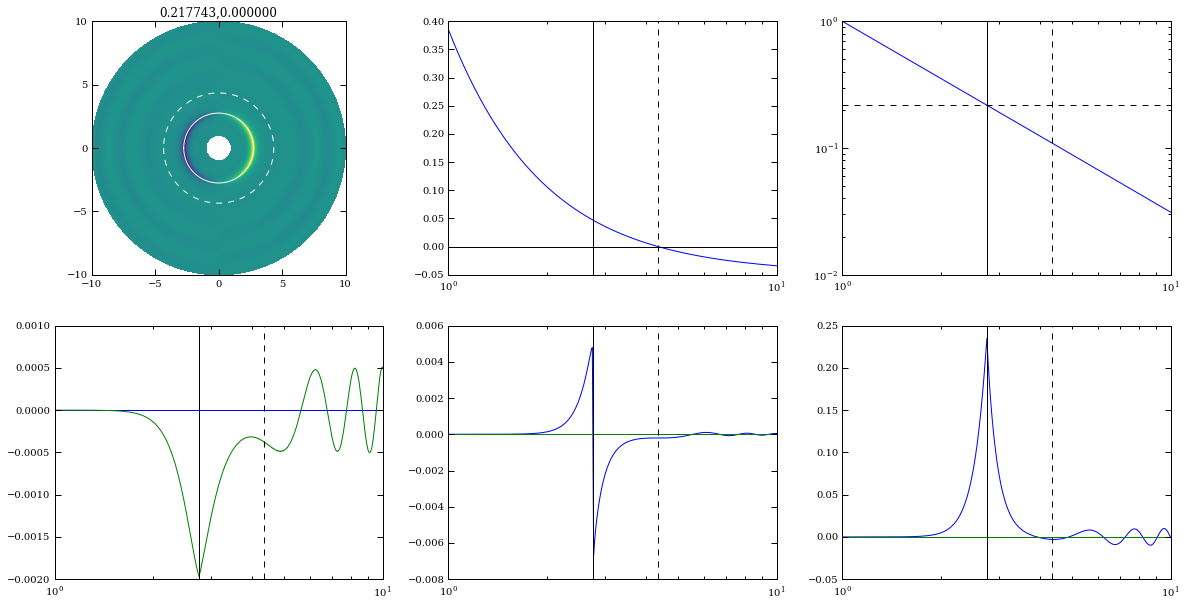

In [25]:
i = np.argwhere( evals.real>0)[-300][0]
#i = np.argwhere( evals.imag>0)[-1][0]
#i = np.argwhere( evals.imag == evals.imag.max())[0][0]
print(i)
fig,axes = plt.subplots(2,3,figsize=(20,10))

for j,p in enumerate(phi):
    dat[:,j] = s[:,i] * np.exp(-1j*m*p)
axes[0,0].pcolormesh(xx,yy,np.real(dat),cmap='viridis')
axes[0,1].semilogx(r,Dfunc(r,evals[i].real,m,disk))
axes[0,1].axhline(0,ls='-',c='k')
axes[0,2].loglog(r,disk.omega(r))
axes[0,2].axhline(evals[i].real,ls='--',c='k')

axes[1,0].semilogx(r,u[:,i].real,r,u[:,i].imag)
axes[1,1].semilogx(r,v[:,i].real,r,v[:,i].imag)
axes[1,2].semilogx(r,s[:,i].real,r,s[:,i].imag)

lrs = r[:-1][np.abs(np.diff(np.sign(Dfunc(r,evals[i].real,m,disk)))) == 2]
crs = r[:-1][np.abs(np.diff(np.sign(disk.omega(r) - np.abs(evals[i])))) == 2]

for cr in crs:
    if cr < r[-1]:
        for ax in axes.flatten()[1:]:
            ax.axvline(cr,ls='-',c='k')
        axes[0,0].plot(cr*np.cos(phi),cr*np.sin(phi),'-w')
        
for lr in lrs:
    if lr < r[-1]:
        for ax in axes.flatten()[1:]:
            ax.axvline(lr,ls='--',c='k')
        axes[0,0].plot(lr*np.cos(phi),lr*np.sin(phi),'--w')

axes[0,0].set_xlim(-r.max(),r.max())
axes[0,0].set_ylim(-r.max(),r.max())
axes[0,0].set_aspect('equal')
axes[0,0].set_title('{:f},{:f}'.format(evals[i].real,evals[i].imag))

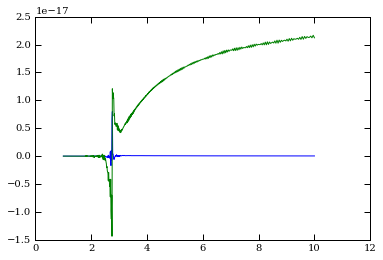

In [27]:
plt.plot(r,(u[:,i]*np.conj(v[:,i])).real)
plt.plot(r,(np.conj(u[:,i])*s[:,i]).real)

In [727]:
func = lambda u: -1./np.sqrt(1.01 + 1 - 2 *np.cos(u))
n = 1e5
m = 10
phi = np.linspace(-np.pi,np.pi,n)
cft = integrate.quad(lambda x: np.cos(m*x)*func(x),-np.pi,np.pi)[0] 
cft += 1j*integrate.quad(lambda x: np.sin(m*x)*func(x),-np.pi,np.pi)[0]


cft /= 2*np.pi
dft = np.fft.rfft(func(phi))/n
print(cft,dft[m])


(-0.13390489280405052+0j) (-0.133905472197-4.20676461568e-05j)


[100, 300, 1000, 3000, 10000, 30000]


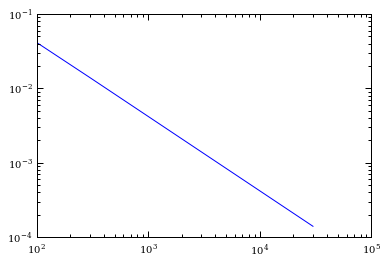

In [741]:
n = [100,300,1000,3000,10000,30000]
print(n)
vals = np.array([np.fft.rfft(func(np.linspace(-np.pi,np.pi,i)))[10]/i for i in n])
plt.loglog(n,np.abs(vals.imag))

In [704]:
-1./np.sqrt(1.01 + .01 - 2)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


nan

In [24]:
planet = Planet(mp=1e-5,a=1,eps=.6,hp=.05)
disk = Disk()

res = np.zeros((100,256),dtype='complex')
dr_res = np.zeros((100,256),dtype='complex')

for i in range(100):
    for j in range(256):
        x = .6 + j*(2-.6)/256.
        m = i+1
        temp =  force(x,m,disk,planet,.01)
        dr_res[i,j] = temp[0,0]
        res[i,j] = temp[1,0]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [25]:
dat = np.fromfile('../src/pot_test.dat',dtype='complex')
cres = dat[:100*256].reshape(100,256)
cdr_res = dat[-100*256:].reshape(100,256)

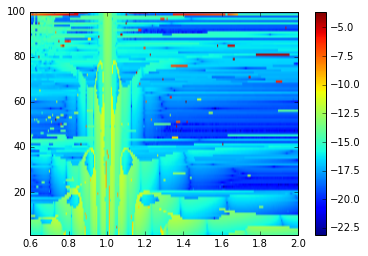

In [48]:
plt.imshow(np.log10(np.sqrt(abs((np.conj(res - cres)*(res-cres)).real))),origin='lower',extent=(.6,2,1,100),aspect='auto')
plt.colorbar()

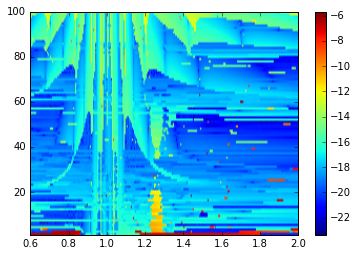

In [29]:
plt.imshow(np.log10(np.sqrt(abs((np.conj(dr_res - cdr_res)*(dr_res-cdr_res)).real))),extent=(.6,2,1,100),aspect='auto')
plt.colorbar()

In [45]:
ind = np.argwhere((res-cres).imag == (res - cres).imag.max())[0]
print(indres[ind[0],ind[1]],cres[ind[0],ind[1]])


8.27133062615e-17j (-0-0.00022757735902j)


In [72]:
n = 20
md = np.random.rand(n)
ld = np.random.rand(n-1)
ud = np.random.rand(n-1)
fd = np.random.rand(n)
mat = np.diag(md) + np.diag(ld,-1) + np.diag(ud,1)
sol = np.linalg.solve(mat,fd)
np.hstack((md,ud,ld,fd,sol)).tofile('../src/input.dat')


In [99]:
n = 20
md = np.array([ np.random.rand(3,3) for i in range(n)])
ld = np.array([ np.random.rand(3,3) for i in range(n-1)])
ud = np.array([ np.random.rand(3,3) for i in range(n-1)])
fd = np.array([ np.random.rand(3,1) for i in range(n)])
sol = thomas_alg_block(ld,md,ud,fd)
np.hstack((md.ravel(),ud.ravel(),ld.ravel(),fd.ravel(),sol.ravel())).tofile('../src/input.dat')



In [98]:
n = 3
A = np.random.rand(n,n)
B = np.random.rand(n,n)
C = np.random.rand(n,n)
D = np.random.rand(n,1)
E = np.random.rand(n,1)
coeffs = np.random.rand(2)

sol_m = coeffs[0]*np.dot(A,B) + coeffs[1]*C 
sol_v = coeffs[0]*np.dot(A,D) + coeffs[1]*E
sol_s = np.linalg.solve(A,D)
sol_sm = np.linalg.solve(A,B)
np.hstack((A.ravel(),B.ravel(),C.ravel(),D.ravel(),E.ravel(),coeffs.ravel(),sol_m.ravel(),sol_v.ravel(),sol_s.ravel(),sol_sm.ravel())).tofile('../src/input.dat')


In [94]:
for i in range(9):
    print('{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}'.format(A.ravel()[i],B.ravel()[i],C.ravel()[i],sol_m.ravel()[i]))

0.347	0.048	0.257	0.061
0.133	0.176	0.051	0.132
0.651	0.858	0.358	0.191
0.803	0.183	0.977	0.091
0.483	0.733	0.316	0.163
0.175	0.584	0.843	0.306
0.541	0.231	0.656	0.067
0.261	0.552	0.131	0.116
0.279	0.492	0.635	0.220


In [97]:
sol_sm

array([[ 0.77518915,  1.20754835, -1.55979307],
       [ 2.30933324,  1.82548707, -0.00234236],
       [-0.78988766, -0.87186754,  1.48497349]])

In [102]:
dat = np.fromfile('../outputs/res.dat')
n = int(dat[0])
dat = dat[1:]
r = dat[:n]
dat = dat[n:]
u = dat[:n] + 1j*dat[n:2*n]
dat[2*n:]
v = dat[:n] + 1j*dat[n:2*n]
dat[2*n:]
s = dat[:n] + 1j*dat[n:2*n]

ValueError: x and y must have same first dimension

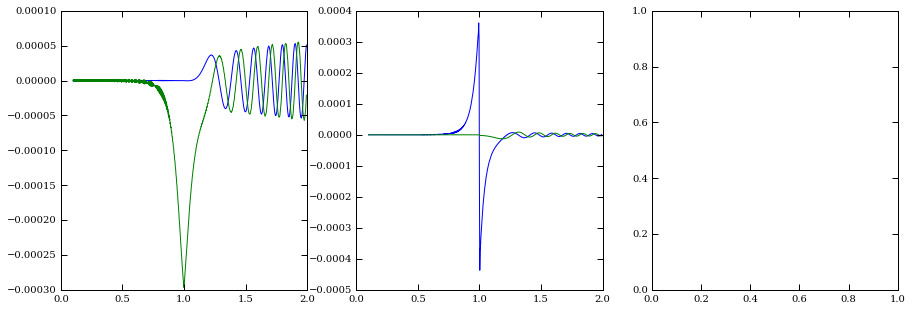

In [240]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(r,u.real,r,u.imag)
axes[1].plot(r,v.real,r,v.imag)
axes[2].plot(r,s.real,r,s.imag)

In [205]:
%run ../pyutils/reader.py

In [254]:
fld = Mode(fname='../outputs/res.dat')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


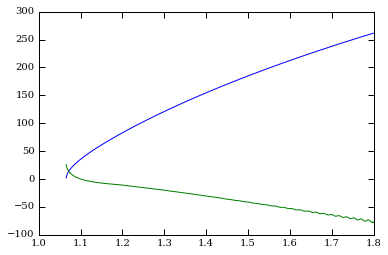

In [255]:
rr = fld.r[fld.r>1]
k = np.sqrt(-Dfunc(rr,1,10,disk)/disk.c2(rr))
plt.plot(rr,k)
dpdr =np.gradient(np.unwrap(fld.phase[fld.r>1],np.pi))/(rr*fld.dlr) - k 
plt.plot(rr,dpdr)
s = np.polyfit(rr[rr>1.3],dpdr[rr>1.3],1)
#plt.plot(rr,dpdr - (s[0]*rr+s[1]))


AttributeError: 'Mode' object has no attribute 'fw'

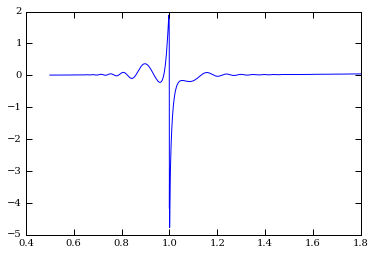

In [239]:
plt.plot(fld.r,(fld.u*np.conj(fld.v)).real)
plt.plot(fld.r,fld.fw)